# Predicting and understanding viewer engagement with educational videos 

With the advent of global online learning platforms, thousands of online courses and tutorial videos have become accesible for milions of viewers all over the world. Because of the vast diversity of content available, finding, filtering and matching these videos with interested learners has led to a challenge.
During this project I will try to address part of this challenge by generating different machine learning models that will try to identify and classify videos according to their features.

## About the prediction problem

One of the most important properties of a video is engagement, defined as how interesting it is for viewers, so that they decide to keep watching. There are many ways to define engagement with video, but one common approach is to estimate it by measuring how much of the video a user watches. If the video is not interesting and does not engage a viewer, they will typically abandon it quickly by watching just a little portion of it.

A first step towards providing the best-matching educational content is to understand which features of educational material make it engaging for learners in general. This is where predictive modeling can be applied, via supervised machine learning. For this assignment, I will try to predict how engaging an educational video is likely to be for viewers, based on a set of features extracted from the video's transcript, audio track, hosting site, and other sources.

## About the dataset

I worked with the VLE Dataset put together by researcher Sahan Bulathwela at University College London (Link to the full dataset can be found <a href="https://github.com/sahanbull/VLE-Dataset" target="_blank">here</a>).
In order to avoid an excessive computational demand, the full dataset (11548, 50) was reduced to smaller size (9239, 10)

Each row in this file corresponds to a single educational video (instances), and the columns include information about diverse properties (features) of the video content as described further below. 

The target label is named `engagement` and was defined as True if the median percentage of the video watched across all viewers was at least 30%, and False otherwise.


**File descriptions** 
    assets/VLE_12k_dataset_v1.txt - Full dataset
    assets/train.csv - Reduced dataset use along this project
    
<br>

**Data fields**

train.csv:

    title_word_count - the number of words in the title of the video.
    
    document_entropy - a score indicating how varied the topics are covered in the video, based on the transcript. Videos with smaller entropy scores will tend to be more cohesive and more focused on a single topic.
    
    freshness - The number of days elapsed between 01/01/1970 and the lecture published date. Videos that are more recent will have higher freshness values.
    
    easiness - A text difficulty measure applied to the transcript. A lower score indicates more complex language used by the presenter.
    
    fraction_stopword_presence - A stopword is a very common word like 'the' or 'and'. This feature computes the fraction of all words that are stopwords in the video lecture transcript.
    
    normalization_rate - Normalisation Rate of Transcript text
    
    speaker_speed - The average speaking rate in words per minute of the presenter in the video.
    
    silent_period_rate - The fraction of time in the lecture video that is silence (no speaking).
    
    engagement - Target label for training. It has been defined as True if learners watched a substantial portion of the video (see description), or False otherwise.
    

## Evaluation

To measure and compare the performance of different classificarion models, I will use different evaluation metrics, but the AUROC (Area Under the Receiver Operating Characteristics) will ultimately used to define the best performing model.

#### Importing all the required libraries

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### 1. Loading the Dataset and Data Overview

In [30]:
train = pd.read_csv("assets/train.csv")
train.head(5)

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,engagement
0,1,9,7.753995,16310,75.583936,0.553664,0.034049,2.997753,0.0,True
1,2,6,8.305269,15410,86.870523,0.584498,0.018763,2.635789,0.0,False
2,3,3,7.965583,15680,81.915968,0.605685,0.030720,2.538095,0.0,False
3,4,9,8.142877,15610,80.148937,0.593664,0.016873,2.259055,0.0,False
4,5,9,8.161250,14920,76.907549,0.581637,0.023412,2.420000,0.0,False


**Lets analyze the summarized info of the train dataset:**

I will use `.info()` method to have a summarized view of the dataset.

As a result I can see for each feature the number of records and datatype.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9239 entries, 0 to 9238
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          9239 non-null   int64  
 1   title_word_count            9239 non-null   int64  
 2   document_entropy            9239 non-null   float64
 3   freshness                   9239 non-null   int64  
 4   easiness                    9239 non-null   float64
 5   fraction_stopword_presence  9239 non-null   float64
 6   normalization_rate          9239 non-null   float64
 7   speaker_speed               9239 non-null   float64
 8   silent_period_rate          9239 non-null   float64
 9   engagement                  9239 non-null   bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 658.8 KB


We can deepen our analysis with the `.describe()` method, with the _include='all'_  parameter so that we can see the Descriptive statistics for every column, including the non numeric columns like "engagement" that contains boolean elements.

In [4]:
train.describe(include="all")

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,engagement
count,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8342
mean,4620.000000,7.701050,7.792685,14808.587509,84.756029,0.612214,0.021354,2.413320,0.146606,NaN
std,2667.213902,3.785066,0.697710,1208.953646,8.303489,0.051872,0.009545,1.588296,0.172030,NaN
min,1.000000,1.000000,0.000000,10830.000000,28.210966,0.000000,0.000000,0.000302,0.000000,NaN
25%,2310.500000,5.000000,7.594235,14070.000000,80.415060,0.589632,0.014974,1.976727,0.000000,NaN
50%,4620.000000,7.000000,7.875103,14750.000000,84.482122,0.613127,0.019843,2.267133,0.104915,NaN
75%,6929.500000,10.000000,8.164166,15600.000000,88.388711,0.634585,0.026288,2.539207,0.250927,NaN


**Attention: The dataset is imbalanced**

If we analyze the number of True/False elements, we can quicky appreciate that the dataset is imbalanced. There aproximately ten timer more instances labeled as False than the ones labeled as True.

In [31]:
train["engagement"].value_counts()

False    8342
True      897
Name: engagement, dtype: int64

**Lets analyze each feature in an independent manner and the correlation among them:**

In order to achieve that lets make histograms for each of the features: *'title_word_count', 'document_entropy', 'freshness', 'easiness', 'fraction_stopword_presence', 'normalization_rate', 'speaker_speed' and 'silent_period_rate'*.

For this analysis I exclude the columns _'id'_ and _'engagement'_.

In [32]:
# I select from the dataframe all the columns that contain the features of interest
features = train.columns[1:-1]
features

Index(['title_word_count', 'document_entropy', 'freshness', 'easiness',
       'fraction_stopword_presence', 'normalization_rate', 'speaker_speed',
       'silent_period_rate'],
      dtype='object')

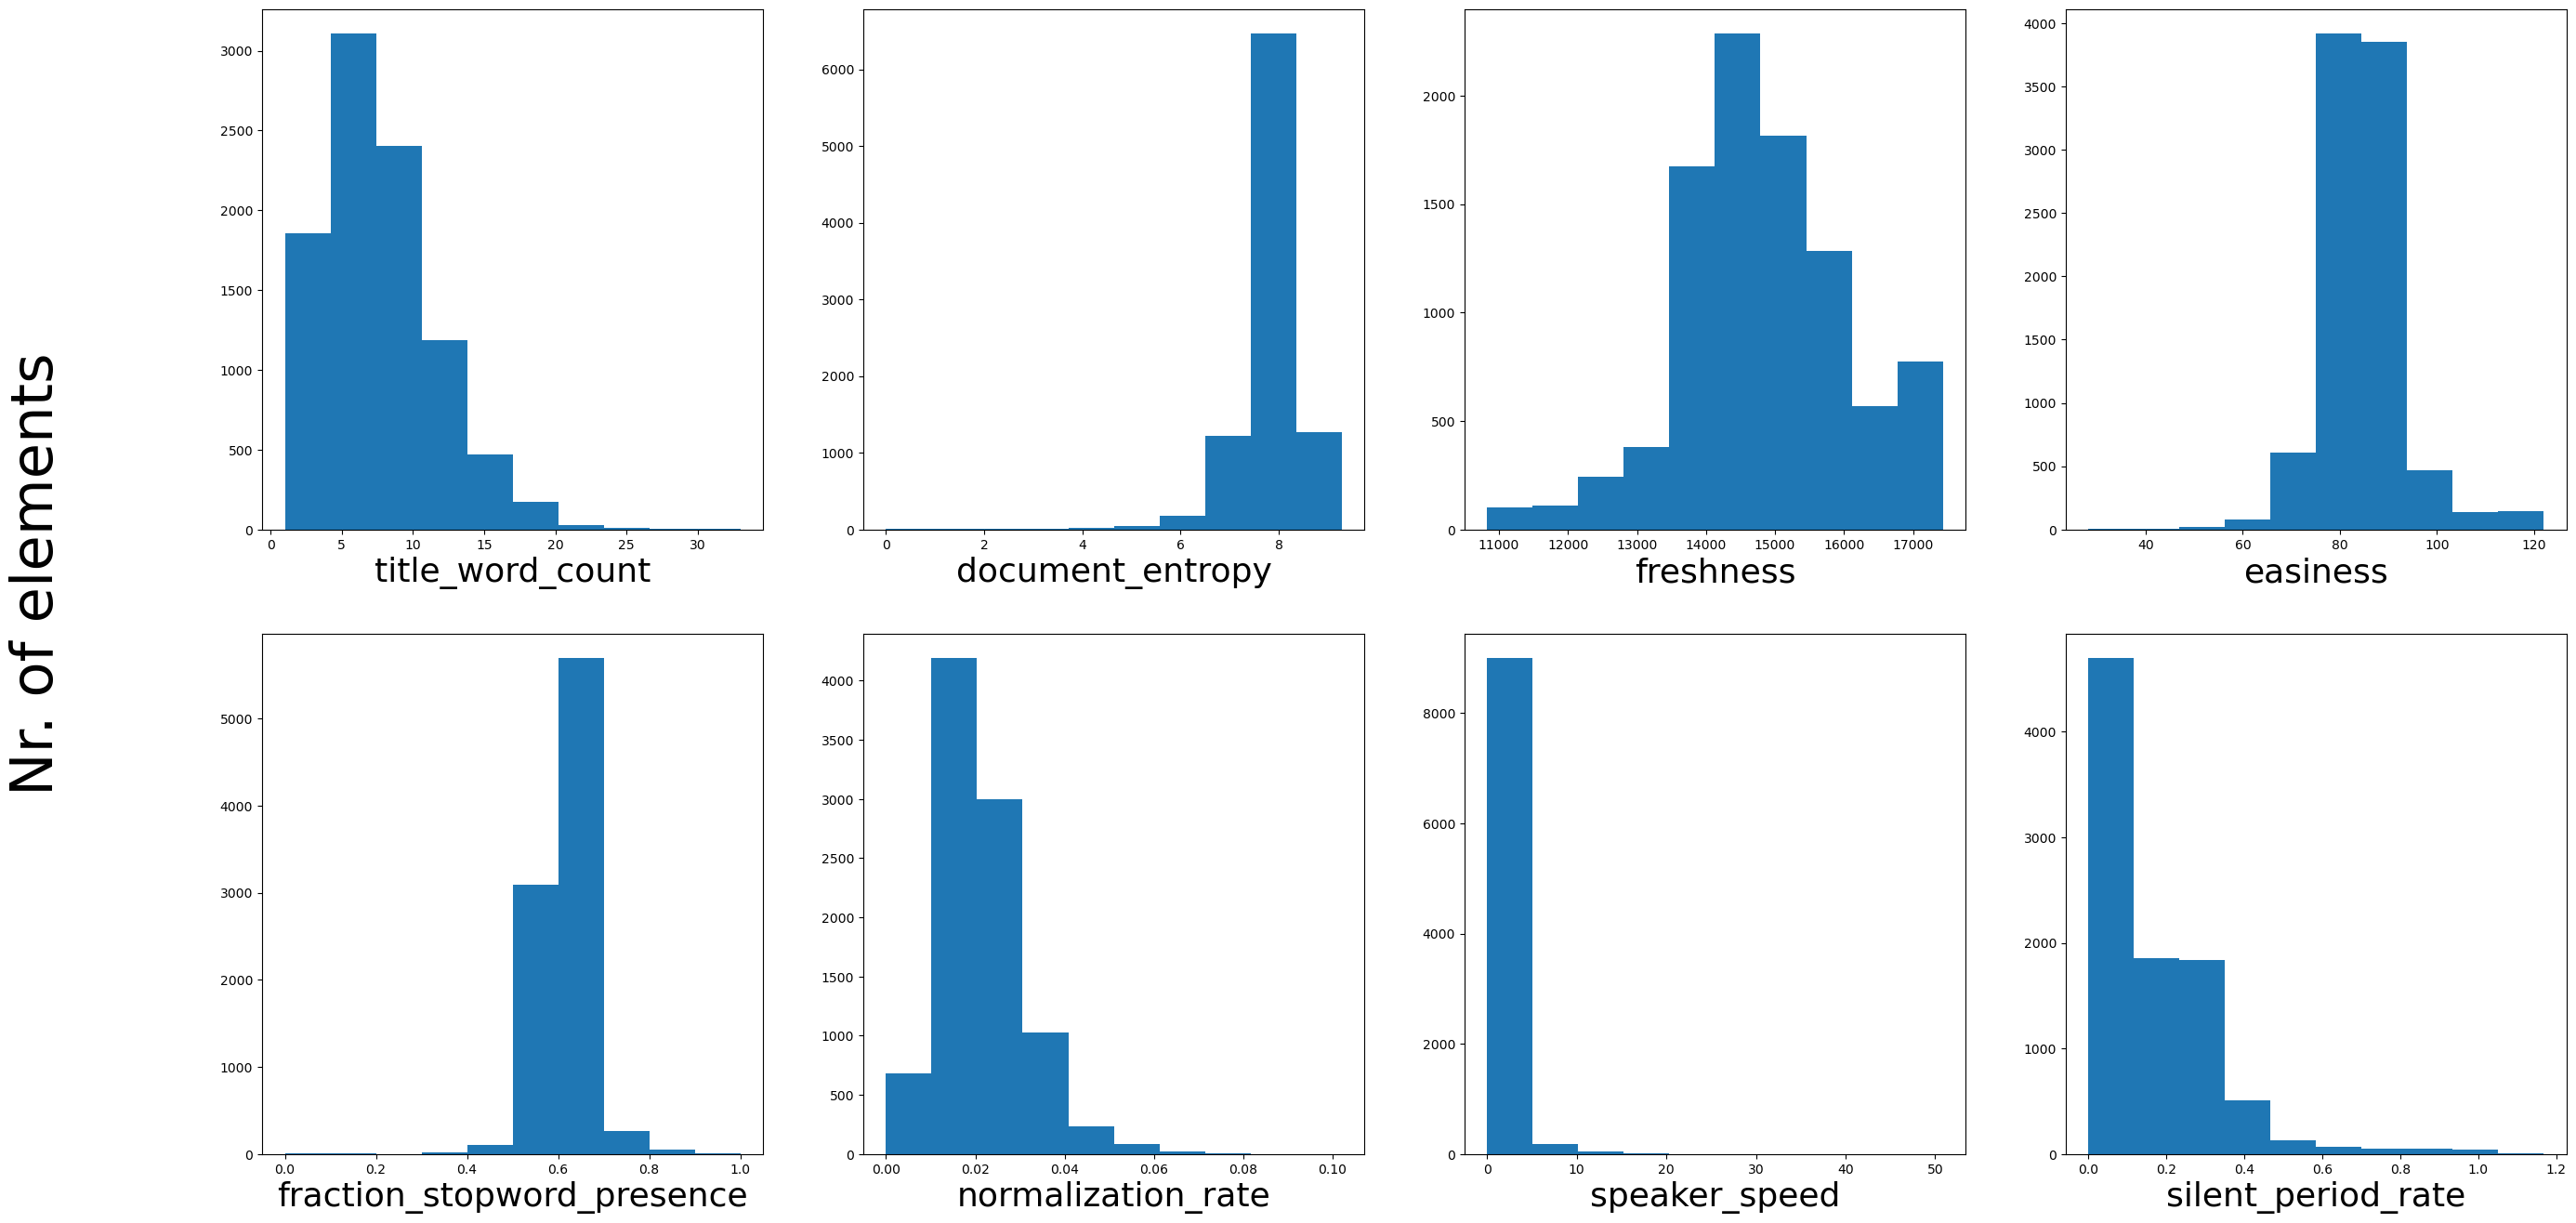

In [7]:
# Creates a figure and initialize a counter i
fig = plt.figure(figsize=(32,16))
i=0
# Iterates over each feature, creates a subaxis within a grid of 2x4, defines its position in it, sets the label of each
# axis, plots the histogram and changes the value of the counter for the next column to be graphed 
# (otherwise the plots will be overlayed).
for feature in features:
    ax = fig.add_subplot(2,4, i+1)
    ax.set_xlabel(feature, fontsize=26)
    plt.hist(train[feature])
 
    i = i + 1
    
fig.text(0.04, 0.5, 'Nr. of elements', va='center', rotation='vertical', fontsize=45);

Thanks to the histograms we can see the distribution of the variables and their range of values.
<br>
It is clear that "freshness" feature has the biggest values (ranging from 11000 to 17000) while "fraction_stopword", "normalization_rate" and silent_period_rate" have the smallest values (within 0-1).<p></p>

**This is an important factor if we will use models that require feature normalization**


**Lets analyze if there is any correlation between the variables of interest**

In [8]:
# Computes the correlations between variables
correlations = train.iloc[:,1:-1].corr()
correlations

,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate
title_word_count,1.000000,0.007861,0.010169,-0.040933,-0.014945,0.039705,-0.076406,-0.007335
document_entropy,0.007861,1.000000,-0.140501,-0.376209,-0.057805,0.038679,0.264153,-0.352060
freshness,0.010169,-0.140501,1.000000,-0.191736,-0.110930,0.131065,0.016699,-0.414012
easiness,-0.040933,-0.376209,-0.191736,1.000000,0.577259,-0.604340,-0.112795,0.423378
fraction_stopword_presence,-0.014945,-0.057805,-0.110930,0.577259,1.000000,-0.291580,-0.026725,0.180411
normalization_rate,0.039705,0.038679,0.131065,-0.604340,-0.291580,1.000000,-0.002837,-0.134752
speaker_speed,-0.076406,0.264153,0.016699,-0.112795,-0.026725,-0.002837,1.000000,-0.111824
silent_period_rate,-0.007335,-0.352060,-0.414012,0.423378,0.180411,-0.134752,-0.111824,1.000000


<AxesSubplot: >

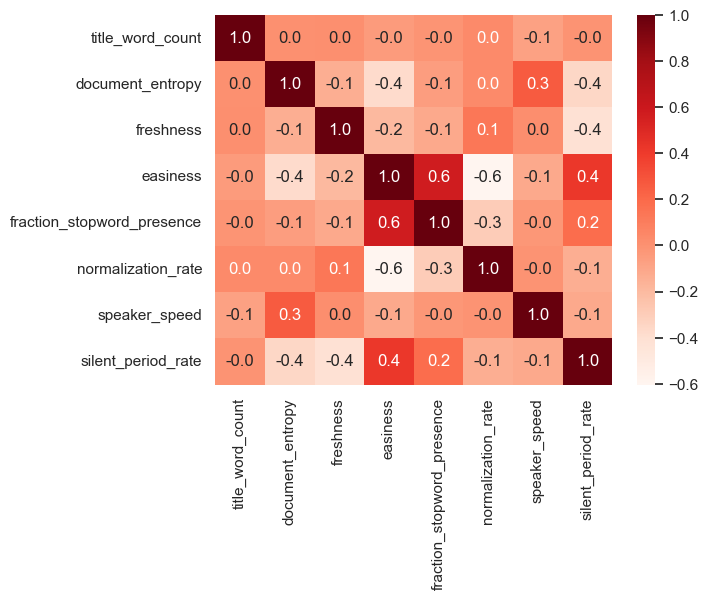

In [9]:
# Graphs the correlations using seaborn
sns.set(font_scale=1)
sns.heatmap(correlations, cmap="Reds", fmt='.1f', cbar=True, annot=True)


### 2. Split train dataset into Training and Testing datasets

As I will be working with classification algorithms that fall under the supervised learning category, the dataset needs to be split into a subset for training and another subset for testing (also known as validation set).

In [33]:
# Adds a new column "engagement_nr" where the boolean from "engagement" is transformed into 0 (False) or 1 (True) 
train["engagement_nr"] = train["engagement"].astype(int)

# Divides the train dataframe in features and labels
X = train[features]
y = train["engagement_nr"]

# Split dataset into Training and Testing sets, containing 70% and 30% of the instances respectively:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [39]:
# In the train and test splits the imbalanced ratio remains aproximately the same (10:1)

print(Counter(y_train))
print(Counter(y_test))

Counter({0: 5851, 1: 616})
Counter({0: 2491, 1: 281})


##### Lets normalize Training and Testing datasets
Data is normalized because some classifiers used in this project work better with normalized data.

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Creates MinMaxScaler object, fits it and transforms X_train and X_test considering the fitting done in X_train
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 3. Machine Learning Modelling Pipeline using with different classifiers and their default parameters
I want to try different classifiers and compare them according to different evaluation metrics and computational requirements.
To accomplish this I will import different classifiers and append them into a list in order to iterate through them to train, test, predict, evaluate and compute time of work.

In [12]:
# Imports all the Classifiers I am interested in testing
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

model_pipeline = []
model_pipeline.append(DummyClassifier())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(LogisticRegression(solver="liblinear"))
model_pipeline.append(SVC(probability=True))
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(GaussianNB())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GradientBoostingClassifier())
model_pipeline.append(MLPClassifier())

#### Pipeline with different classifiers

Initially different classifiers will be evaluated with their defaults parameters.
For each one of them I will compute:
1. accuracy
2. recall
3. precision
4. AUROC
5. Confusion matrix

In [13]:
from sklearn.metrics import accuracy_score, roc_curve, auc, recall_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import timeit

model_list = ["Dummy Classifier", "KNN Classifier", "Logistic Regression", "SVC", "Decision Tree", "Gaussian Naive Bayes",
            "RandomForestClassifier", "Gradient Boosting","MLPClassifier"]


acc_list =[]
auc_list = []
cm_list = []
time_list = []
recall_list = []
precision_list = []

for model in model_pipeline:
    # Some models work better with scaled datasets
    if model in ["KNN Classifier", "SVC", "MLPClassifier"]:
        X_train = X_train_scaled
        X_test = X_test_scaled
    
    # Here I start measuring time
    start = timeit.default_timer()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_list.append(accuracy_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred))
    y_scores = model.predict_proba(X_test) # predict_proba returns 2 columns of data
    fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1]) # I choose the 2nd columns that contains the probabilities of being classified with label 1 (engagement True)
    auc_list.append(round(auc(fpr,tpr),2))
    cm_list.append(confusion_matrix(y_test, y_pred))
    
    end = timeit.default_timer()
    total_time = end - start
    time_list.append(total_time)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to

#### Results

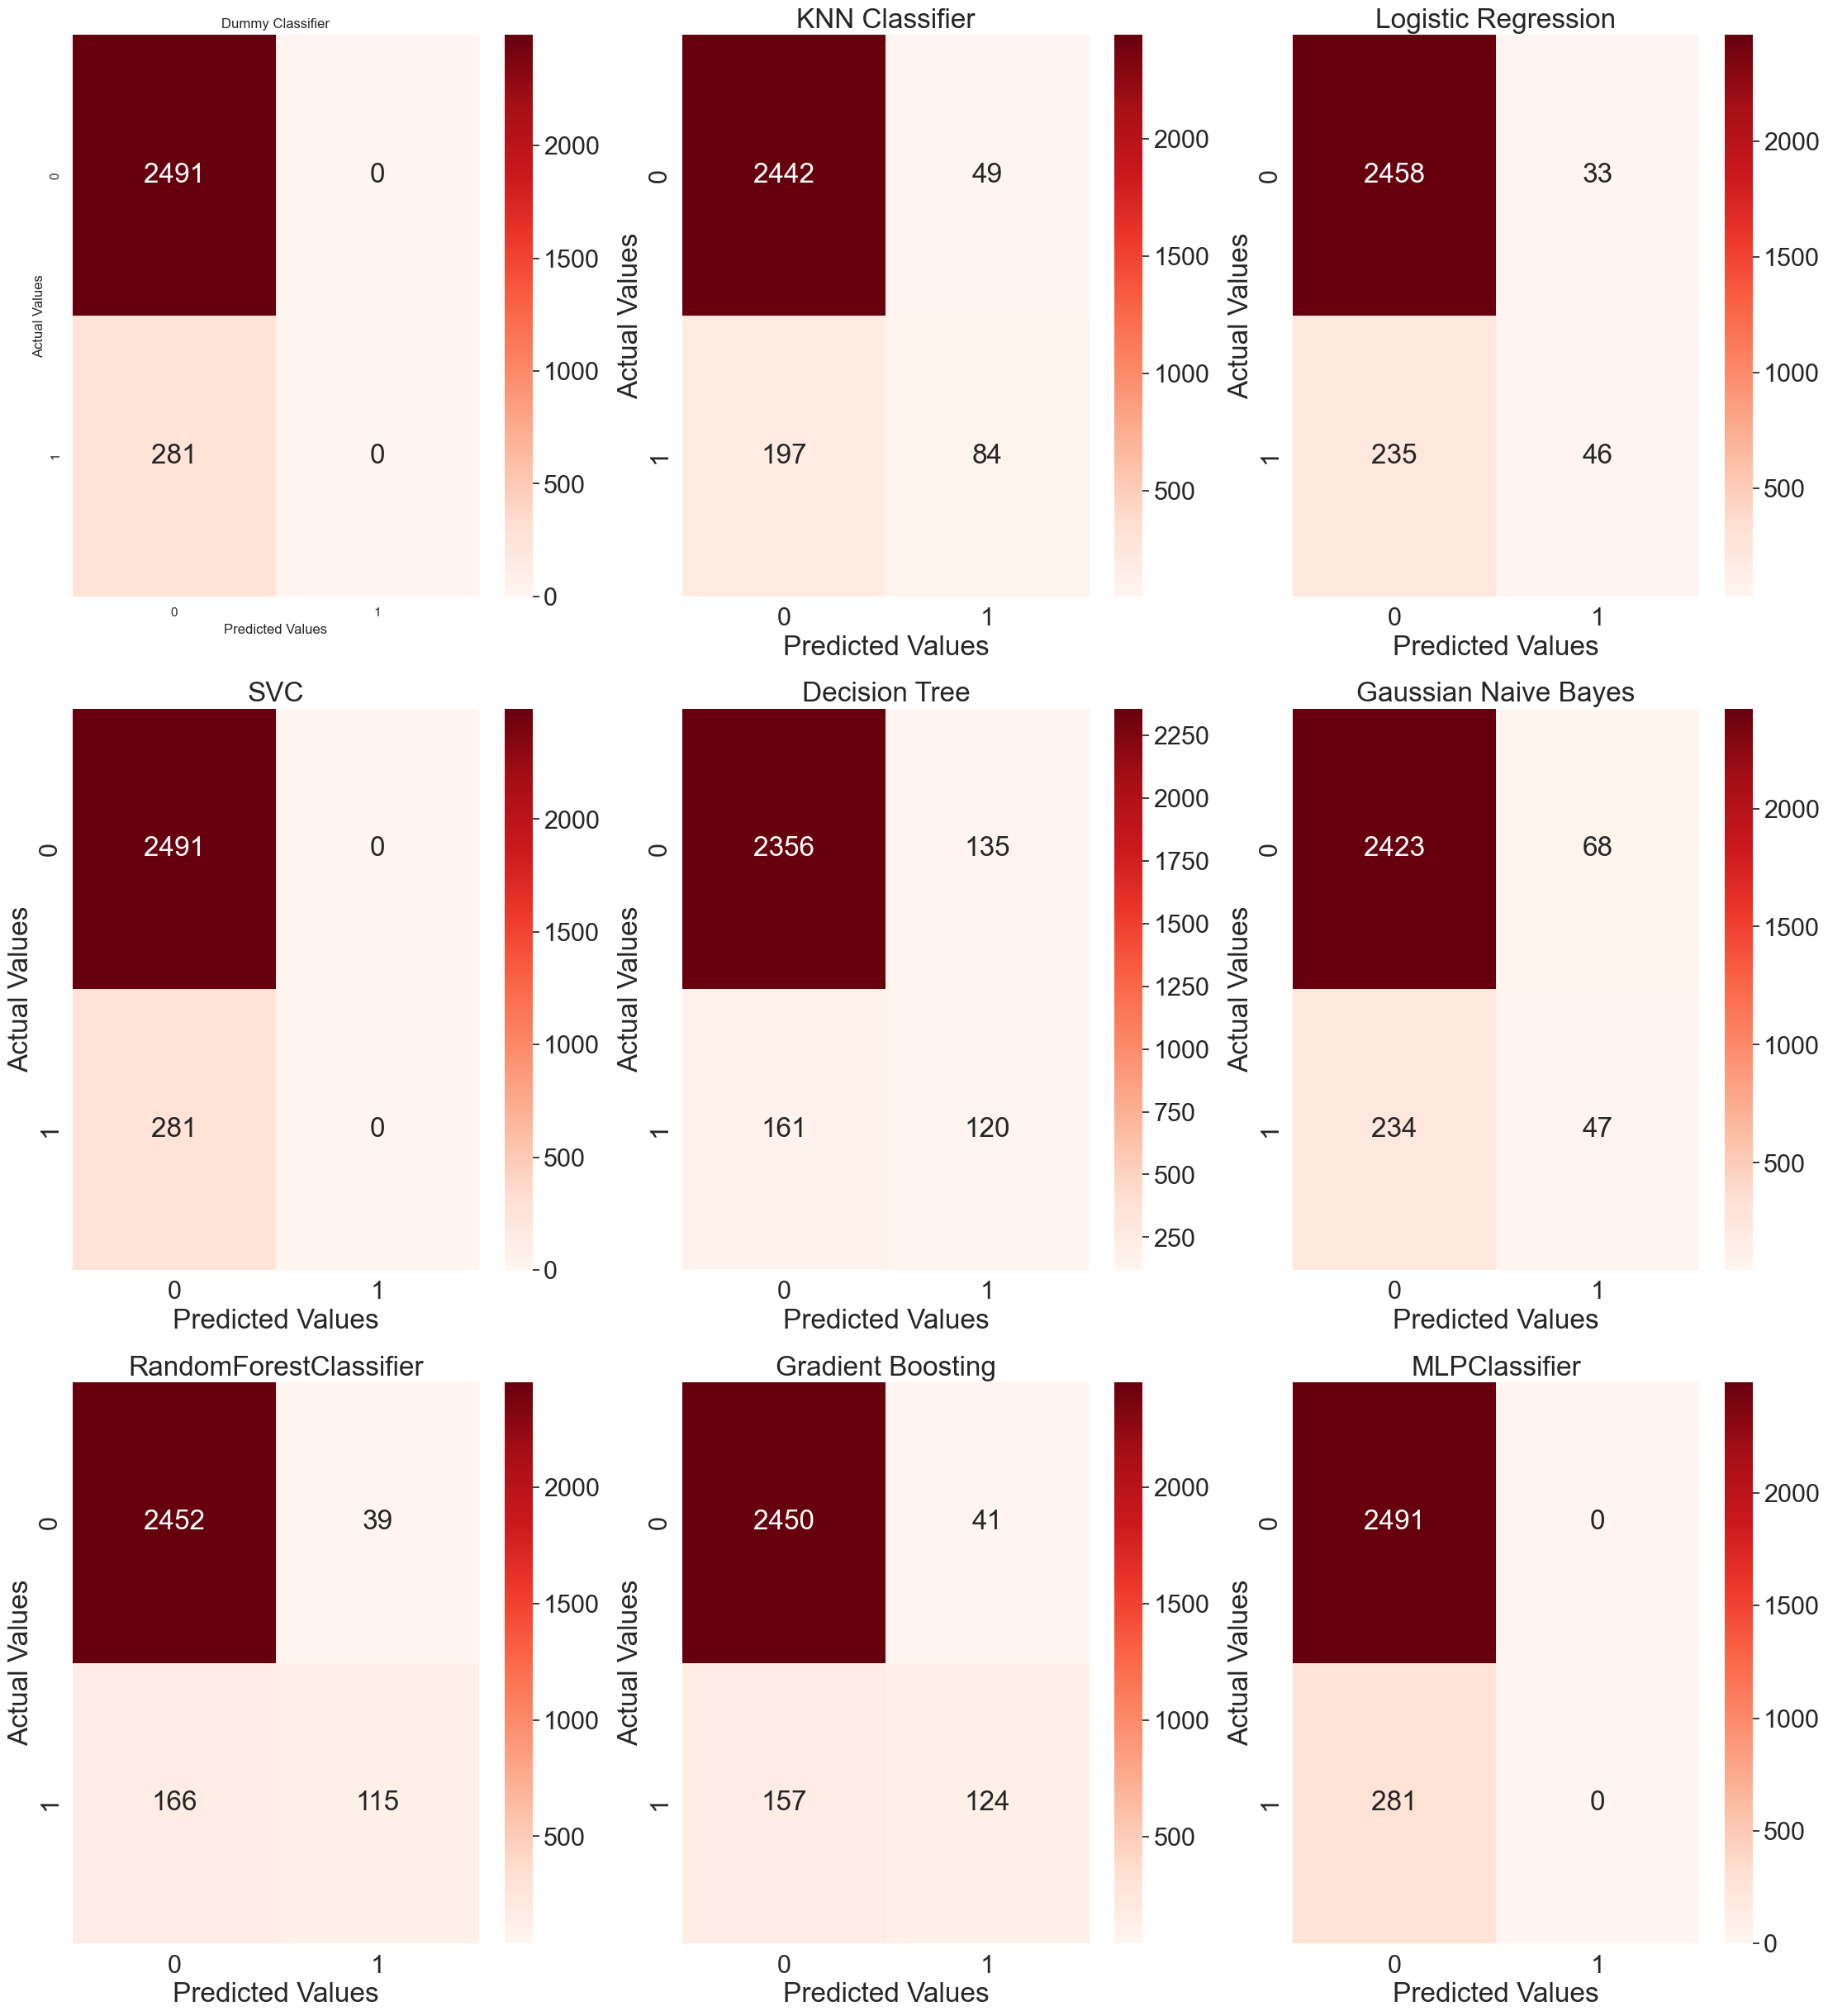

In [14]:
# Confusion Matrixes

import seaborn as sns


fig = plt.figure(figsize=(27,30))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(3,3, i+1).set_title(model)
    sns.set(font_scale=2)
    cm_plot = sns.heatmap(cm, annot=True, fmt='g', cmap = "Reds")
    cm_plot.set_xlabel("Predicted Values")
    cm_plot.set_ylabel("Actual Values")
    

In [15]:
# Making a dataframe with all the metrics and computational time
result_df = pd.DataFrame({"Model": model_list, "Accuracy":acc_list,"AUROC":auc_list, "Recall":recall_list, "Precision":precision_list, "Time":time_list})

# Sorting the multiindexed df
result_df = result_df.sort_values('AUROC', ascending=False)

result_df

,Model,Accuracy,AUROC,Recall,Precision,Time
7,Gradient Boosting,0.928571,0.88,0.441281,0.751515,1.954907
6,RandomForestClassifier,0.926046,0.87,0.409253,0.746753,1.717014
2,Logistic Regression,0.903319,0.82,0.163701,0.582278,0.055058
5,Gaussian Naive Bayes,0.891053,0.82,0.167260,0.408696,0.018991
1,KNN Classifier,0.911255,0.74,0.298932,0.631579,0.266563
4,Decision Tree,0.893218,0.69,0.427046,0.470588,0.099542
0,Dummy Classifier,0.898629,0.50,0.000000,0.000000,0.023549
3,SVC,0.898629,0.42,0.000000,0.000000,5.918426
8,MLPClassifier,0.898629,0.32,0.000000,0.000000,0.642911


#### First conslusions using different classifiers and their default parameters
- The dataset is imbalanced and we are interested in identifying the minority class. By analyzing the results it becomes clear that the classifiers have poor performance while predicting the positive class (minority class) and instead are biased towards predicting the negative class (majority class).

- In this specific case, the accuracy scores turned out to be unuseful as evaluation metric. All the accuracy values are around 90% just because the models were able to predict accurately the majority class (TN), just as much as the DummyClassifier!

- It is clear that all models are able to predict properly the majority class (TN), but they all have problems identifying the minority class (TP). This is reflected in the low Recall values obtained in all classifiers, meaning that from all the positive labeled instances (FN+TP), just a little proportion were predicted as TP. Furthermore, even the best model, being Gradient Boosting Decision Trees, struggles when predicting positive labels. Thanks to the precision score, we can see that around 75% of the positive predictions turn to be TP and the remaining 25% predictions are FP.

- The best Recall, Precision and AUROC values were obtained by Gradient Boosted Decision Trees and Random Forest with their default parameters. These models were also two of the most time consuming models.

- As I am interested in identifying the engaging videos/minority class, the recall and AUROC metrics are the ones that I would like to optimize in the future models. 

- To optimize the models for this metrics some hyperparameter search will be done and the imbalanced data will be balanced with under- and over-sampling methods.






### Hypermarameter tunning: Finding the best parameters for the different models

In this step, some of the previously used classifiers will be used with a grid of parameter with the objective of finding the values that will increase de AUROC.



In [56]:
from sklearn.model_selection import GridSearchCV

model_pipeline2 = []
grid_values2 = []

model_pipeline2.append(KNeighborsClassifier())
grid_values2.append({'n_neighbors': [1,3,5,10,100,1000],
                    'weights': ['uniform', 'distance']})

model_pipeline2.append(LogisticRegression())
grid_values2.append({'solver':['liblinear'],
                     'C': [0.001,0.1,1,100,1000]})

model_pipeline2.append(SVC(probability=True))
grid_values2.append({'kernel':['rbf'], 
                     'gamma': [0.01, 0.1, 1]})

model_pipeline2.append(GradientBoostingClassifier())
grid_values2.append({'n_estimators': [10, 100],
                     'max_depth': [3, 5]})

model_pipeline2.append(RandomForestClassifier())
grid_values2.append({'n_estimators': [1, 5, 10],
                     'max_features':[4, 8]})

model_pipeline2.append(MLPClassifier())
grid_values2.append({'solver':['lbfgs'],
                    'hidden_layer_sizes': [[10], [10,10]],
                    'alpha': [0.0001, 1.0, 100]})



model_list2 = ["KNN Classifier", "Logistic Regression", "SVC", "Gradient Boosting", "RandomForestClassifier", 
               "MLPClassifier"]


acc_list2 =[]
auc_list2 = []
cm_list2 = []
time_list2 = []
recall_list2 = []
precision_list2 = []
best_params_list= []
gridsearch_time_list = []


for model,parameters in zip(model_pipeline2, grid_values2):
    # Some models work better with scaled datasets
    if model in ["KNN Classifier", "SVC", "MLPClassifier"]:
        X_train = X_train_scaled
        X_test = X_test_scaled
    
    # Here I do the grid search process 
    # Time is not computed while te best_params_ are searched
    initial_time = timeit.default_timer()
    #clf = GridSearchCV(model, param_grid = parameters, scoring = 'roc_auc')
    clf = GridSearchCV(model, param_grid = parameters, scoring = 'recall')
    
    # Once the best_params_ have been found I start computing the time required for the training, predictions and metrics
    start = timeit.default_timer()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_list2.append(accuracy_score(y_test, y_pred))
    recall_list2.append(recall_score(y_test, y_pred))
    precision_list2.append(precision_score(y_test, y_pred))
    y_scores = clf.predict_proba(X_test) # predict_proba returns 2 columns of data
    fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1]) # I choose the 2nd columns that contains the probabilities of being classified with label 1 (engagement True)
    auc_list2.append(round(auc(fpr,tpr),2))
    cm_list2.append(confusion_matrix(y_test, y_pred))
    best_params_list.append(clf.best_params_)
    end = timeit.default_timer()
    gridsearch_time = start - initial_time
    gridsearch_time_list.append(gridsearch_time)
    total_time = end - start
    time_list2.append(total_time)
    print(model) # Just to see in the screen where the process is working
    
    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

KNeighborsClassifier()
LogisticRegression()
SVC(probability=True)
GradientBoostingClassifier()
RandomForestClassifier()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the nu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACH

MLPClassifier()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division`

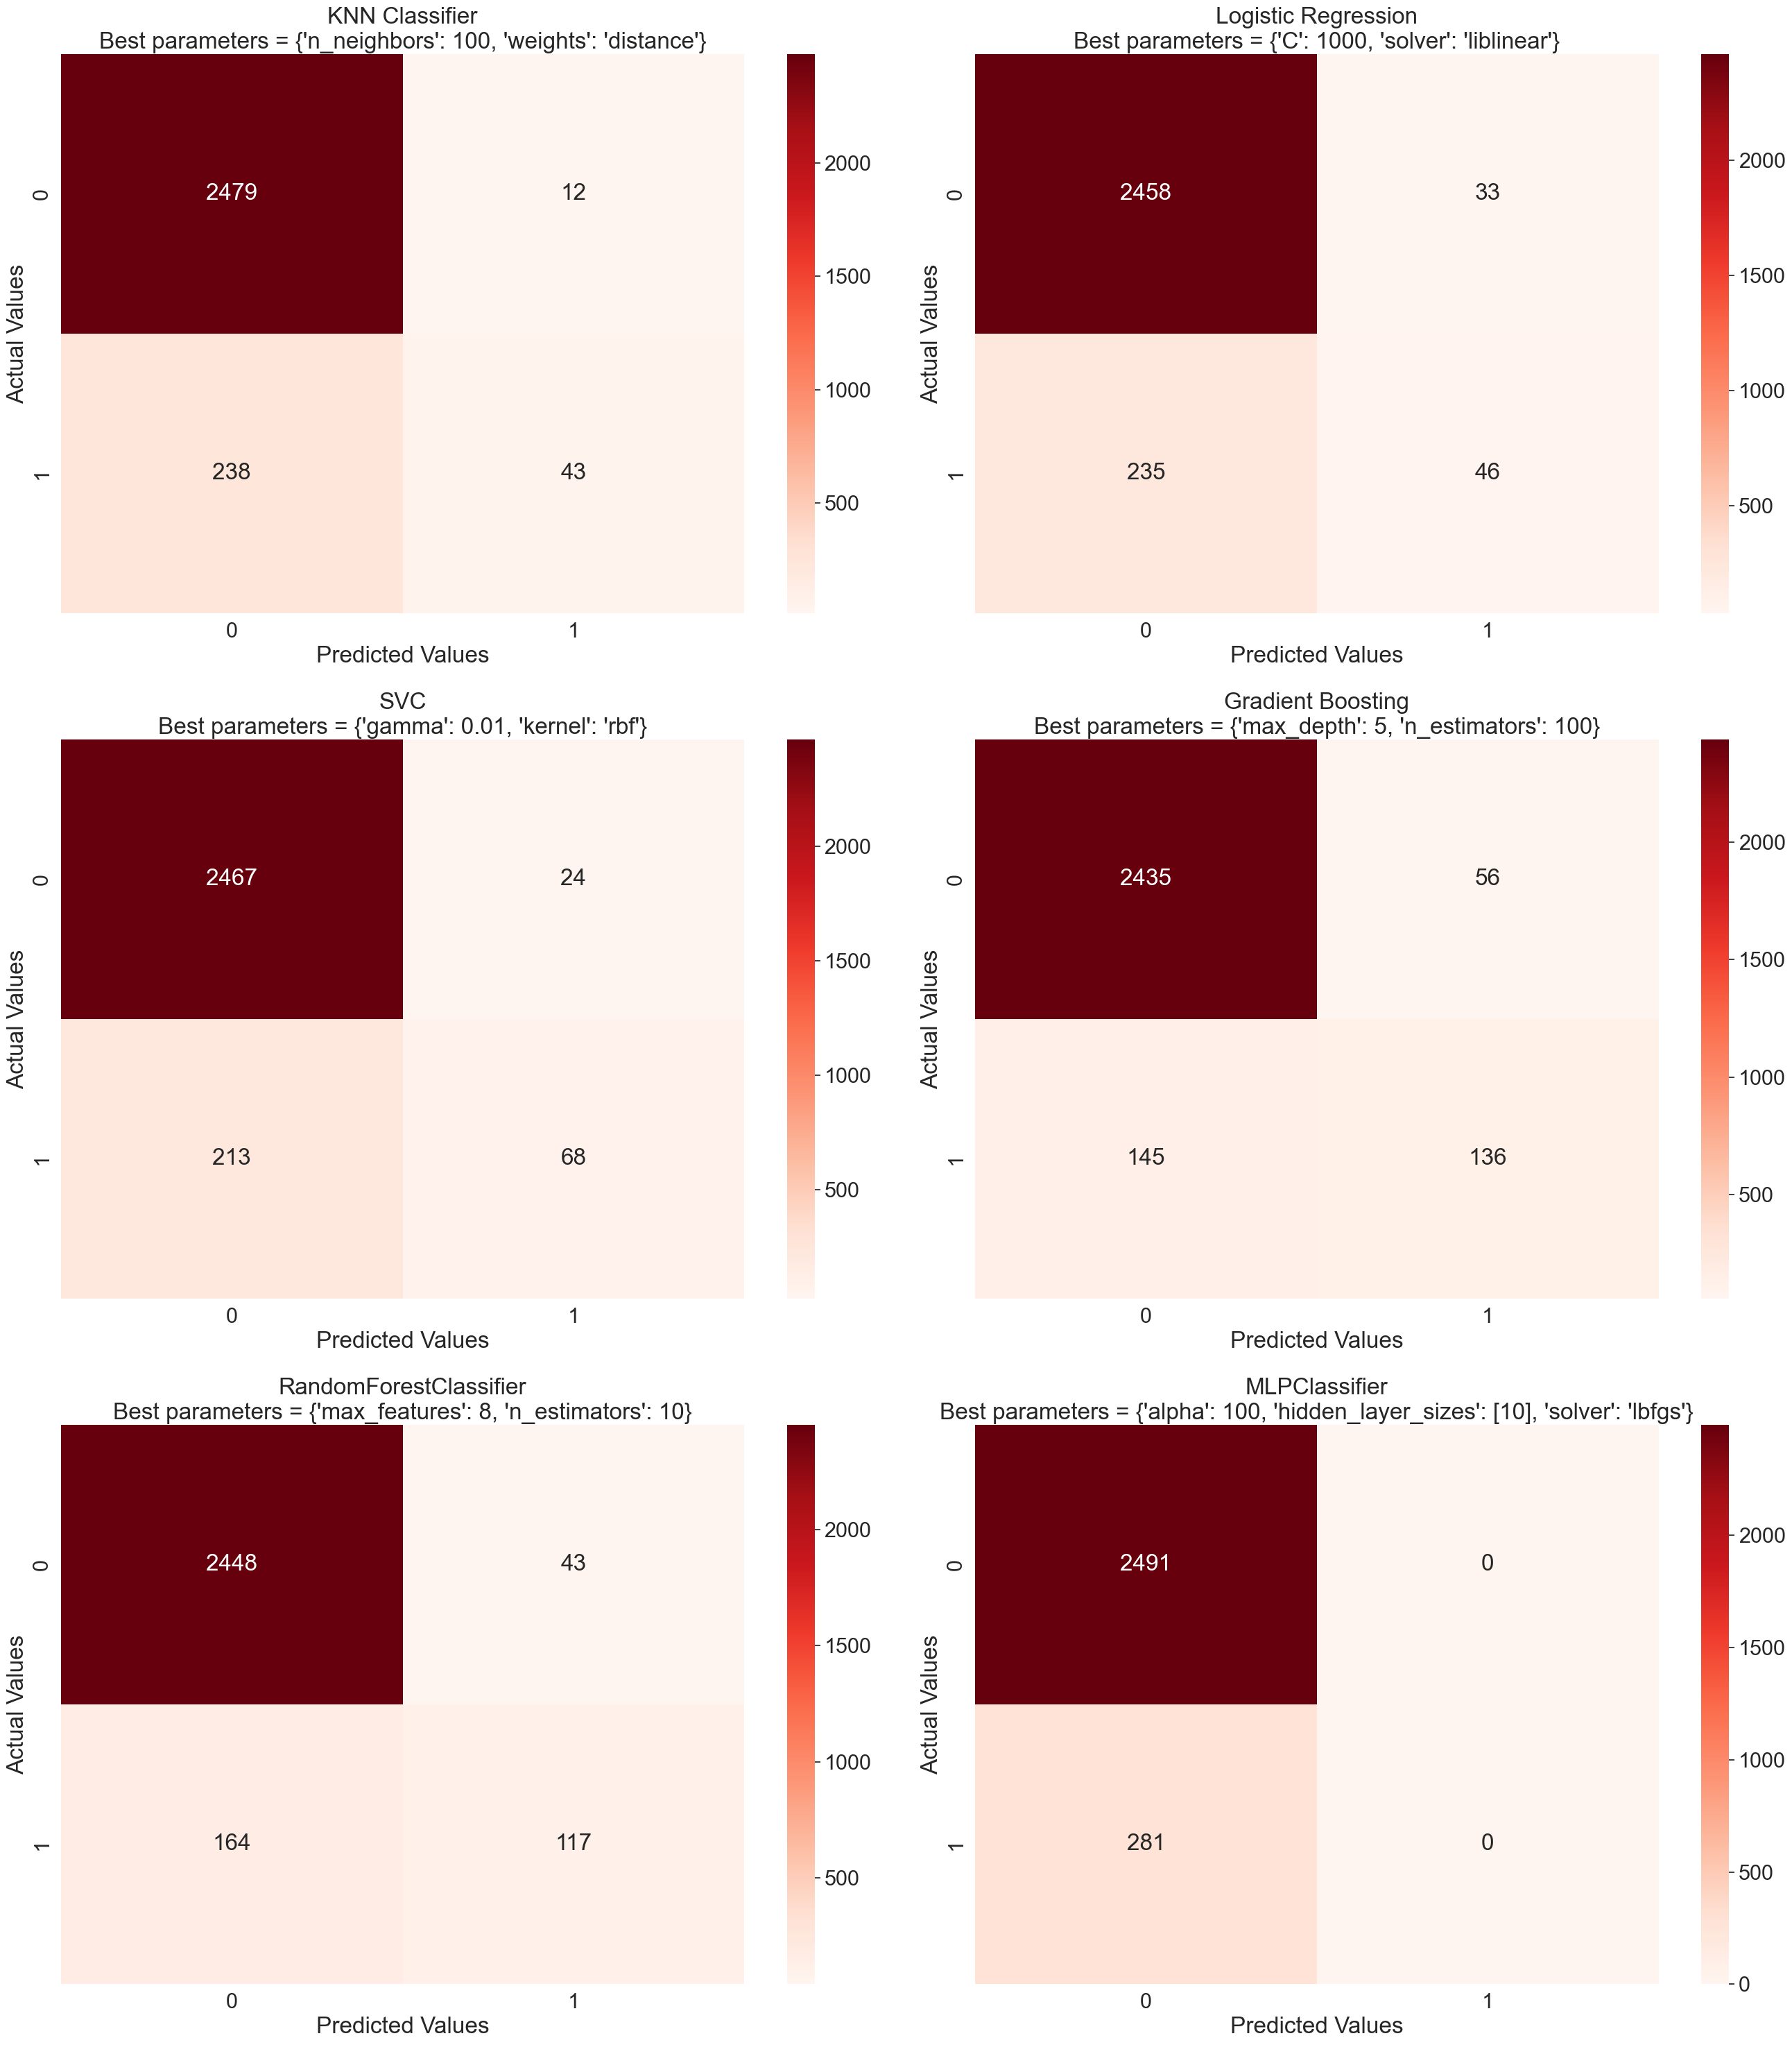

In [55]:
fig = plt.figure(figsize=(27,30))
for i in range(len(cm_list2)):
    cm = cm_list2[i]
    model = model_list2[i]
    best_params =f'\nBest parameters = {best_params_list[i]}'
    sub = fig.add_subplot(3,2, i+1).set_title(model + best_params)
    sns.set(font_scale=2)
    cm_plot = sns.heatmap(cm, annot=True, fmt='g', cmap = "Reds")
    cm_plot.set_xlabel("Predicted Values")
    cm_plot.set_ylabel("Actual Values")

plt.tight_layout()


In [53]:
result_df2 = pd.DataFrame({"Model": model_list2, "Accuracy":acc_list2,"AUROC":auc_list2, "Recall":recall_list2, "Precision":precision_list2, "Time":time_list2})


# Sorting the multiindexed df
result_df2 = result_df2.sort_values('AUROC', ascending=False)

result_df2

,Model,Accuracy,AUROC,Recall,Precision,Time
3,Gradient Boosting,0.927489,0.88,0.483986,0.708333,25.876241
4,RandomForestClassifier,0.925325,0.83,0.416370,0.731250,5.810267
1,Logistic Regression,0.903319,0.82,0.163701,0.582278,0.854705
0,KNN Classifier,0.909812,0.79,0.153025,0.781818,6.997250
2,SVC,0.914502,0.71,0.241993,0.739130,312.869764
5,MLPClassifier,0.898629,0.50,0.000000,0.000000,7.332663


#### Conslusions using different classifiers and hyperparamaters with imbalanceddata

- If we compare the metric values from Random Forest and Gradient Boosting classifiers using the default parameter or hyperparameters tweeking, we can see that there was no improvement. The AUROC remain more or less the same or it even went down in Gradient Boosting. The same can be observed with Recall and precision, were the values did not improve or the even got down.

- These results show that the hyperparameters chosen here were not good enough toimprove the detection of the minority class.

- The only classifier that got a significative improvement was SVC, switching from 0.42 to 0.71

### Balancing the dataset

As the dataset is imbalanced with 90% instances labeled as 0 and 10% as 1, I will test different balancing methods and evaluate them with the previously used classifiers with their default parameters.

Important Note!
* For all the following tests, the original split of the data (train/test) will be used in here to compare the results between methodologies.
* The X_train/y_train subsets will be balanced and used to train the classifiers.
* The X_test/y_test subsets will be used to predict the classes and compute the different metrics.
* By doing this, there will be no data leakage and all the results will be comparable as they all used the same test subsets.

#### UNDERSAMPLING: One-Sided Selection for Undersampling
One-Sided Selection, or OSS for short, is an undersampling technique that combines Tomek Links and the Condensed Nearest Neighbor (CNN) Rule.
Specifically, Tomek Links are ambiguous points on the class boundary and are identified and removed in the majority class. The CNN method is then used to remove redundant examples from the majority class that are far from the decision boundary.
This technique combines both methodologies, it keeps and deletes examples from the majority class.
As a result, I might expect a large number of redundant examples from the majority class to be removed from the interior of the distribution (e.g. away from the class boundary).

In [42]:
# Undersample and plot imbalanced dataset with One-Sided Selection
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import OneSidedSelection

# summarize class distribution
counter_pre = Counter(y_train)
print(f'Number of classes before undersampling: {counter_pre}')

# define the undersampling method
undersample = OneSidedSelection(n_neighbors=1, n_seeds_S=200)
# transform the dataset
X_train_balanced, y_train_balanced = undersample.fit_resample(X_train, y_train)

# summarize the new class distribution
counter_post = Counter(y_train_balanced)
print(f'Number of classes after undersampling: {counter_post}')
print(f'The new ration for the balanced dataset is = 1:{round(counter_post[0]/counter_post[1])}')


Number of classes before undersampling: Counter({0: 5851, 1: 616})


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Number of classes after undersampling: Counter({0: 3227, 1: 616})
The new ration for the balanced dataset is = 1:5


In [43]:
# Split dataset into Training and Testing sets, containing 70% and 30% of the instances respectively:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Creates MinMaxScaler object, fits it and transforms X_train and X_test considering the fitting done in X_train
scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

In [44]:
model_pipeline = []
model_pipeline.append(DummyClassifier())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(LogisticRegression(solver="liblinear"))
model_pipeline.append(SVC(probability=True))
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(GaussianNB())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GradientBoostingClassifier())
model_pipeline.append(MLPClassifier())

model_list = ["Dummy Classifier", "KNN Classifier", "Logistic Regression", "SVC", "Decision Tree", "Gaussian Naive Bayes",
            "Random Forest", "Gradient Boosting","MLP Classifier"]
acc_list =[]
auc_list = []
cm_list = []
time_list = []
recall_list = []
precision_list = []

for model in model_pipeline:
    # Some models work better with scaled datasets
    if model in ["KNN Classifier", "SVC", "MLPClassifier"]:
        X_train = X_train_scaled
        X_test = X_test_scaled
    
    # Here I start measuring time
    start = timeit.default_timer()
    
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    acc_list.append(accuracy_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred))
    y_scores = model.predict_proba(X_test) # predict_proba returns 2 columns of data
    fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1]) # I choose the 2nd columns that contains the probabilities of being classified with label 1 (engagement True)
    auc_list.append(round(auc(fpr,tpr),2))
    cm_list.append(confusion_matrix(y_test, y_pred))
    
    end = timeit.default_timer()
    total_time = end - start
    time_list.append(total_time)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to

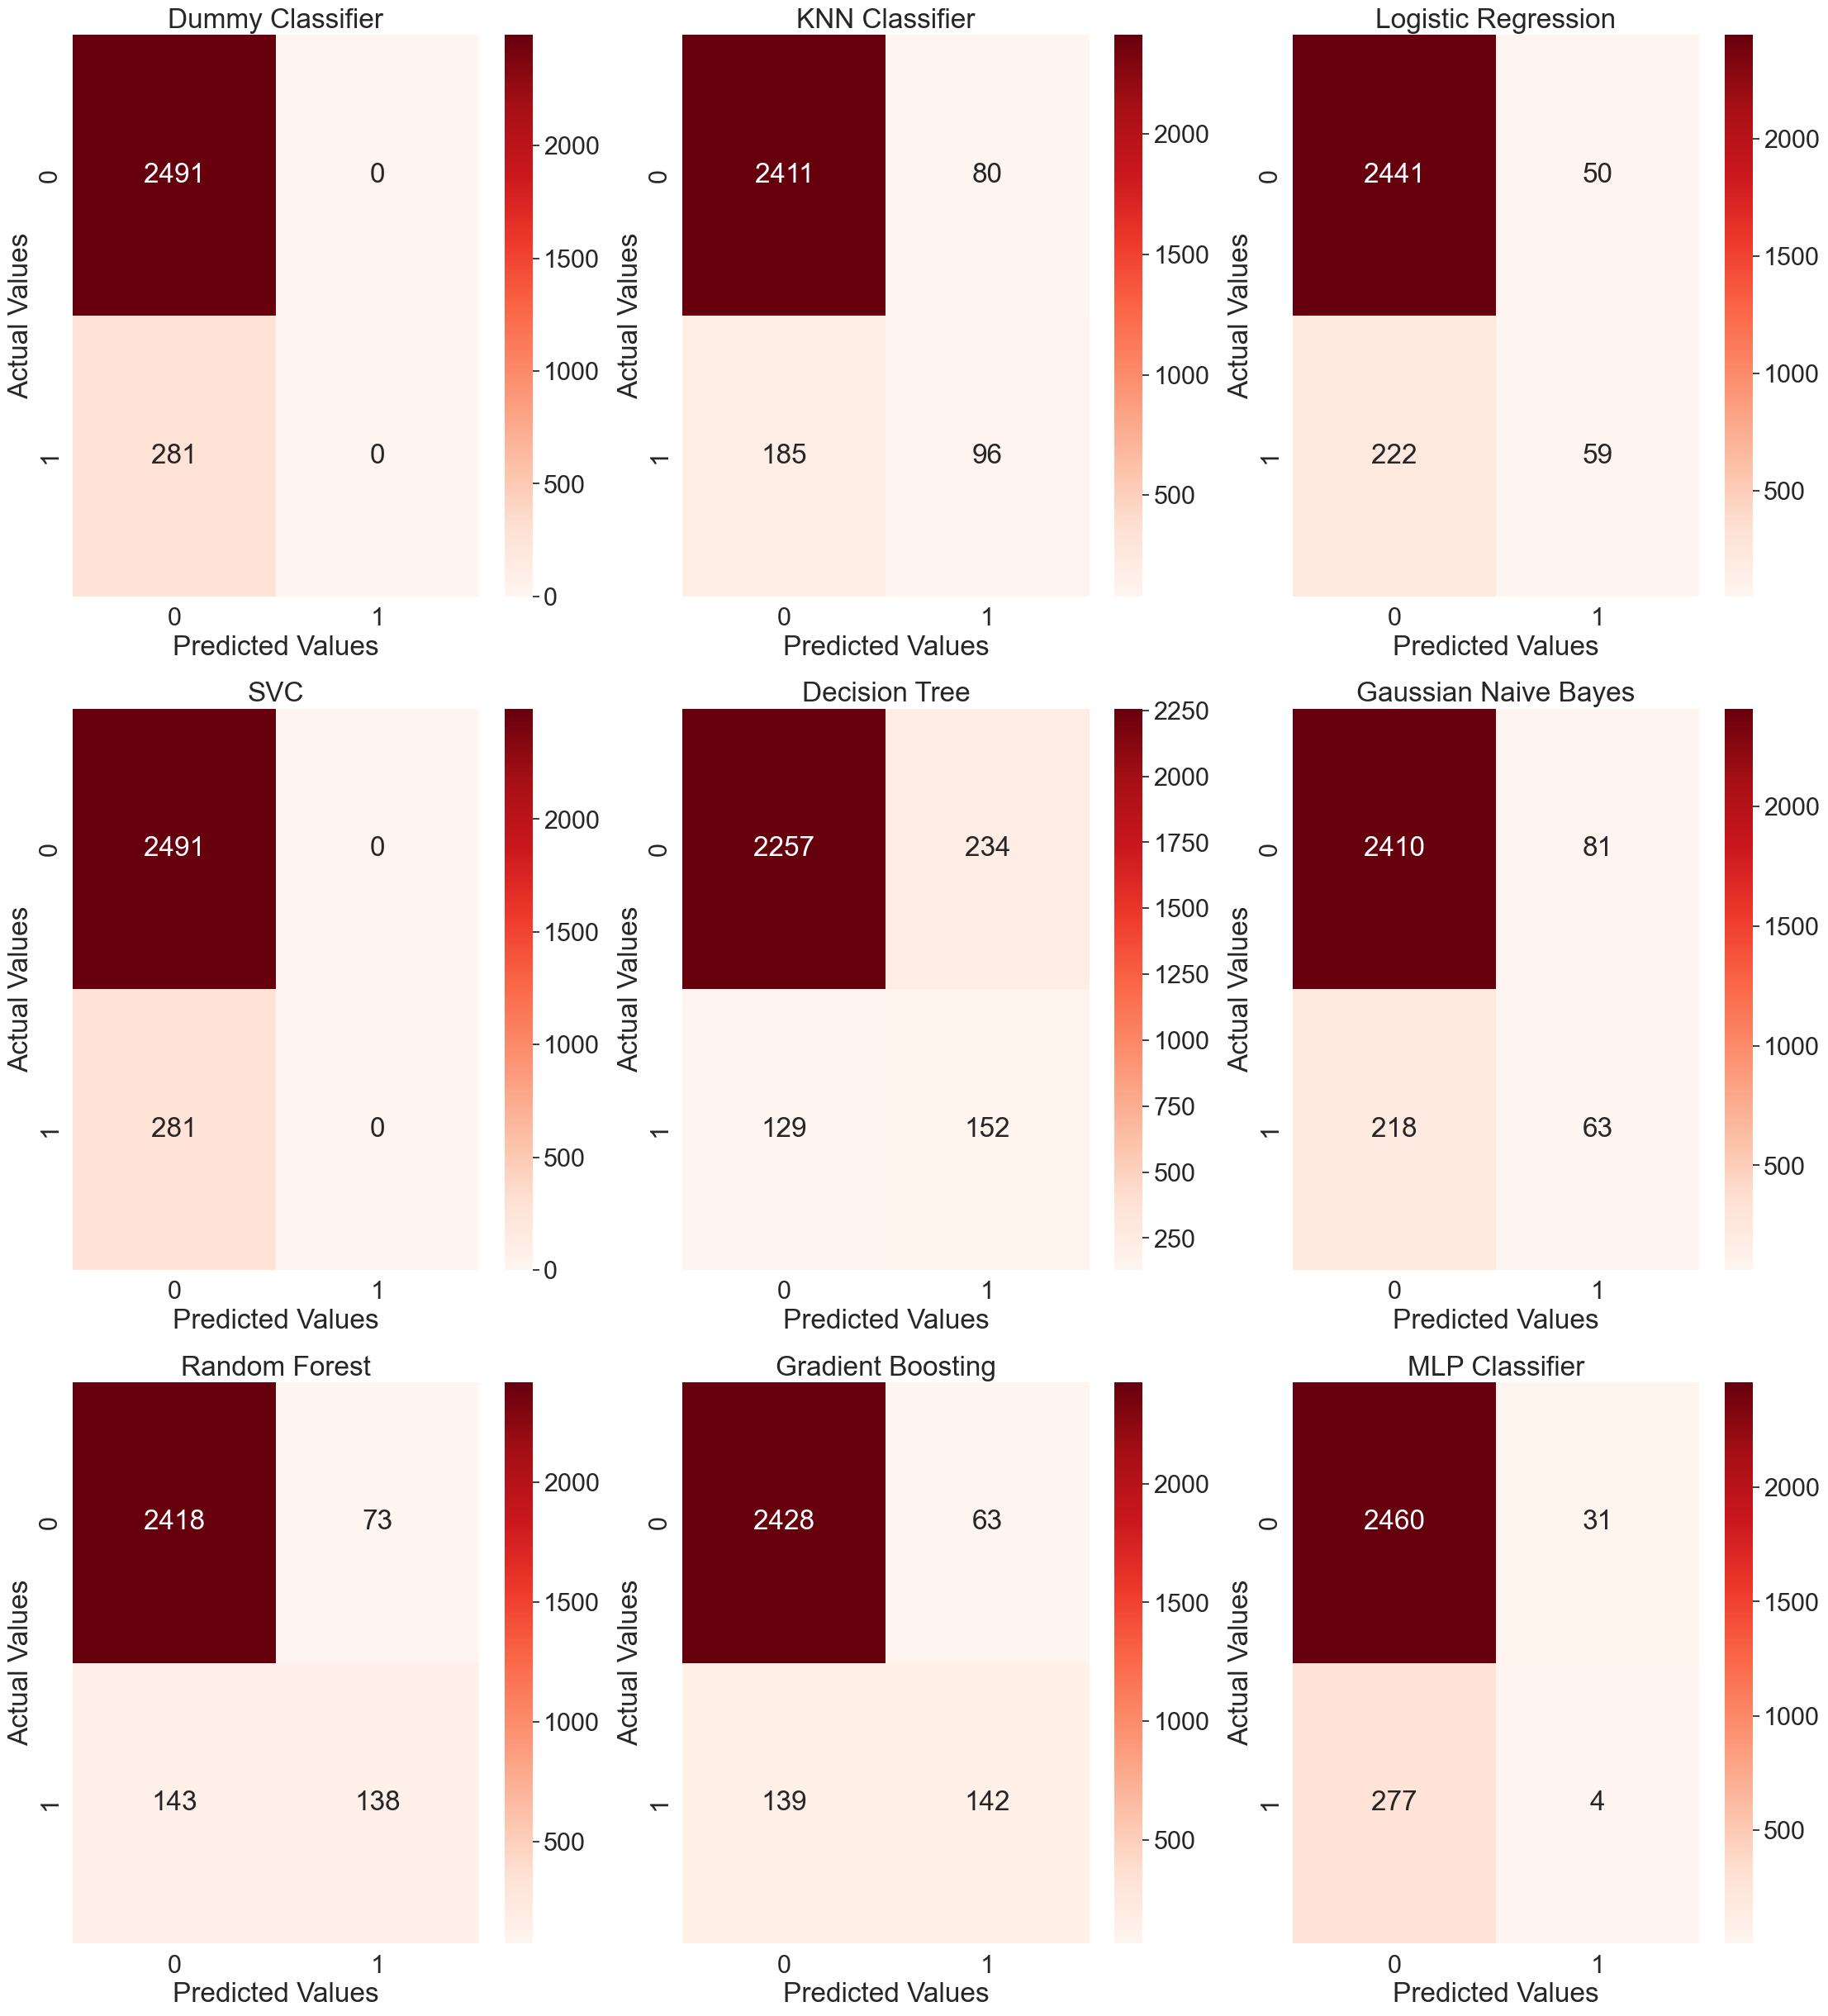

In [45]:
fig = plt.figure(figsize=(27,30))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(3,3, i+1).set_title(model)
    sns.set(font_scale=2)
    cm_plot = sns.heatmap(cm, annot=True, fmt='g', cmap = "Reds")
    cm_plot.set_xlabel("Predicted Values")
    cm_plot.set_ylabel("Actual Values")
    

In [46]:
result_df_undersampling_onesided = pd.DataFrame({"Model": model_list, "Accuracy":acc_list,"AUROC":auc_list, "Recall":recall_list, "Precision":precision_list, "Time":time_list})
result_df_undersampling_onesided = result_df_undersampling_onesided.sort_values('AUROC', ascending=False)
result_df_undersampling_onesided

,Model,Accuracy,AUROC,Recall,Precision,Time
6,Random Forest,0.922078,0.87,0.491103,0.654028,1.131659
7,Gradient Boosting,0.927128,0.87,0.505338,0.692683,1.166768
2,Logistic Regression,0.901876,0.82,0.209964,0.541284,0.038926
5,Gaussian Naive Bayes,0.892136,0.82,0.224199,0.437500,0.017438
1,KNN Classifier,0.904401,0.74,0.341637,0.545455,0.299062
4,Decision Tree,0.869048,0.72,0.540925,0.393782,0.061028
0,Dummy Classifier,0.898629,0.50,0.000000,0.000000,0.014297
8,MLP Classifier,0.888889,0.48,0.014235,0.114286,0.780091
3,SVC,0.898629,0.33,0.000000,0.000000,4.189951


### Near Miss Undersampling - Method that selects examples to keep

Near Miss refers to a collection of undersampling methods that select examples based on the distance of majority class examples to minority class examples
NFrom the three versions of this technique I will use NearMiss-3 that involves selecting a given number of majority class examples for each example in the minority class that are closest.
The NearMiss-3 seems desirable, given that it will only keep those majority class examples that are on the decision boundary.


In [47]:
# Undersample and plot imbalanced dataset with One-Sided Selection
from sklearn.datasets import make_classification
from imblearn.under_sampling import NearMiss

# summarize class distribution
counter_pre = Counter(y_train)
print(f'Number of classes before undersampling: {counter_pre}')

# define the undersampling method
undersample = NearMiss(version=3, n_neighbors_ver3=3)
# transform the dataset
X_train_balanced, y_train_balanced = undersample.fit_resample(X_train, y_train)

# summarize the new class distribution
counter_post = Counter(y_train_balanced)
print(f'Number of classes after undersampling: {counter_post}')
print(f'The new ration for the balanced dataset is = 1:{round(counter_post[0]/counter_post[1])}')

Number of classes before undersampling: Counter({0: 5851, 1: 616})
Number of classes after undersampling: Counter({0: 616, 1: 616})
The new ration for the balanced dataset is = 1:1


In [48]:
# Split dataset into Training and Testing sets, containing 70% and 30% of the instances respectively:
#X_train, X_test, y_train2, y_test2 = train_test_split(X, y, test_size=0, random_state=0)

# Creates MinMaxScaler object, fits it and transforms X_train and X_test considering the fitting done in X_train
scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


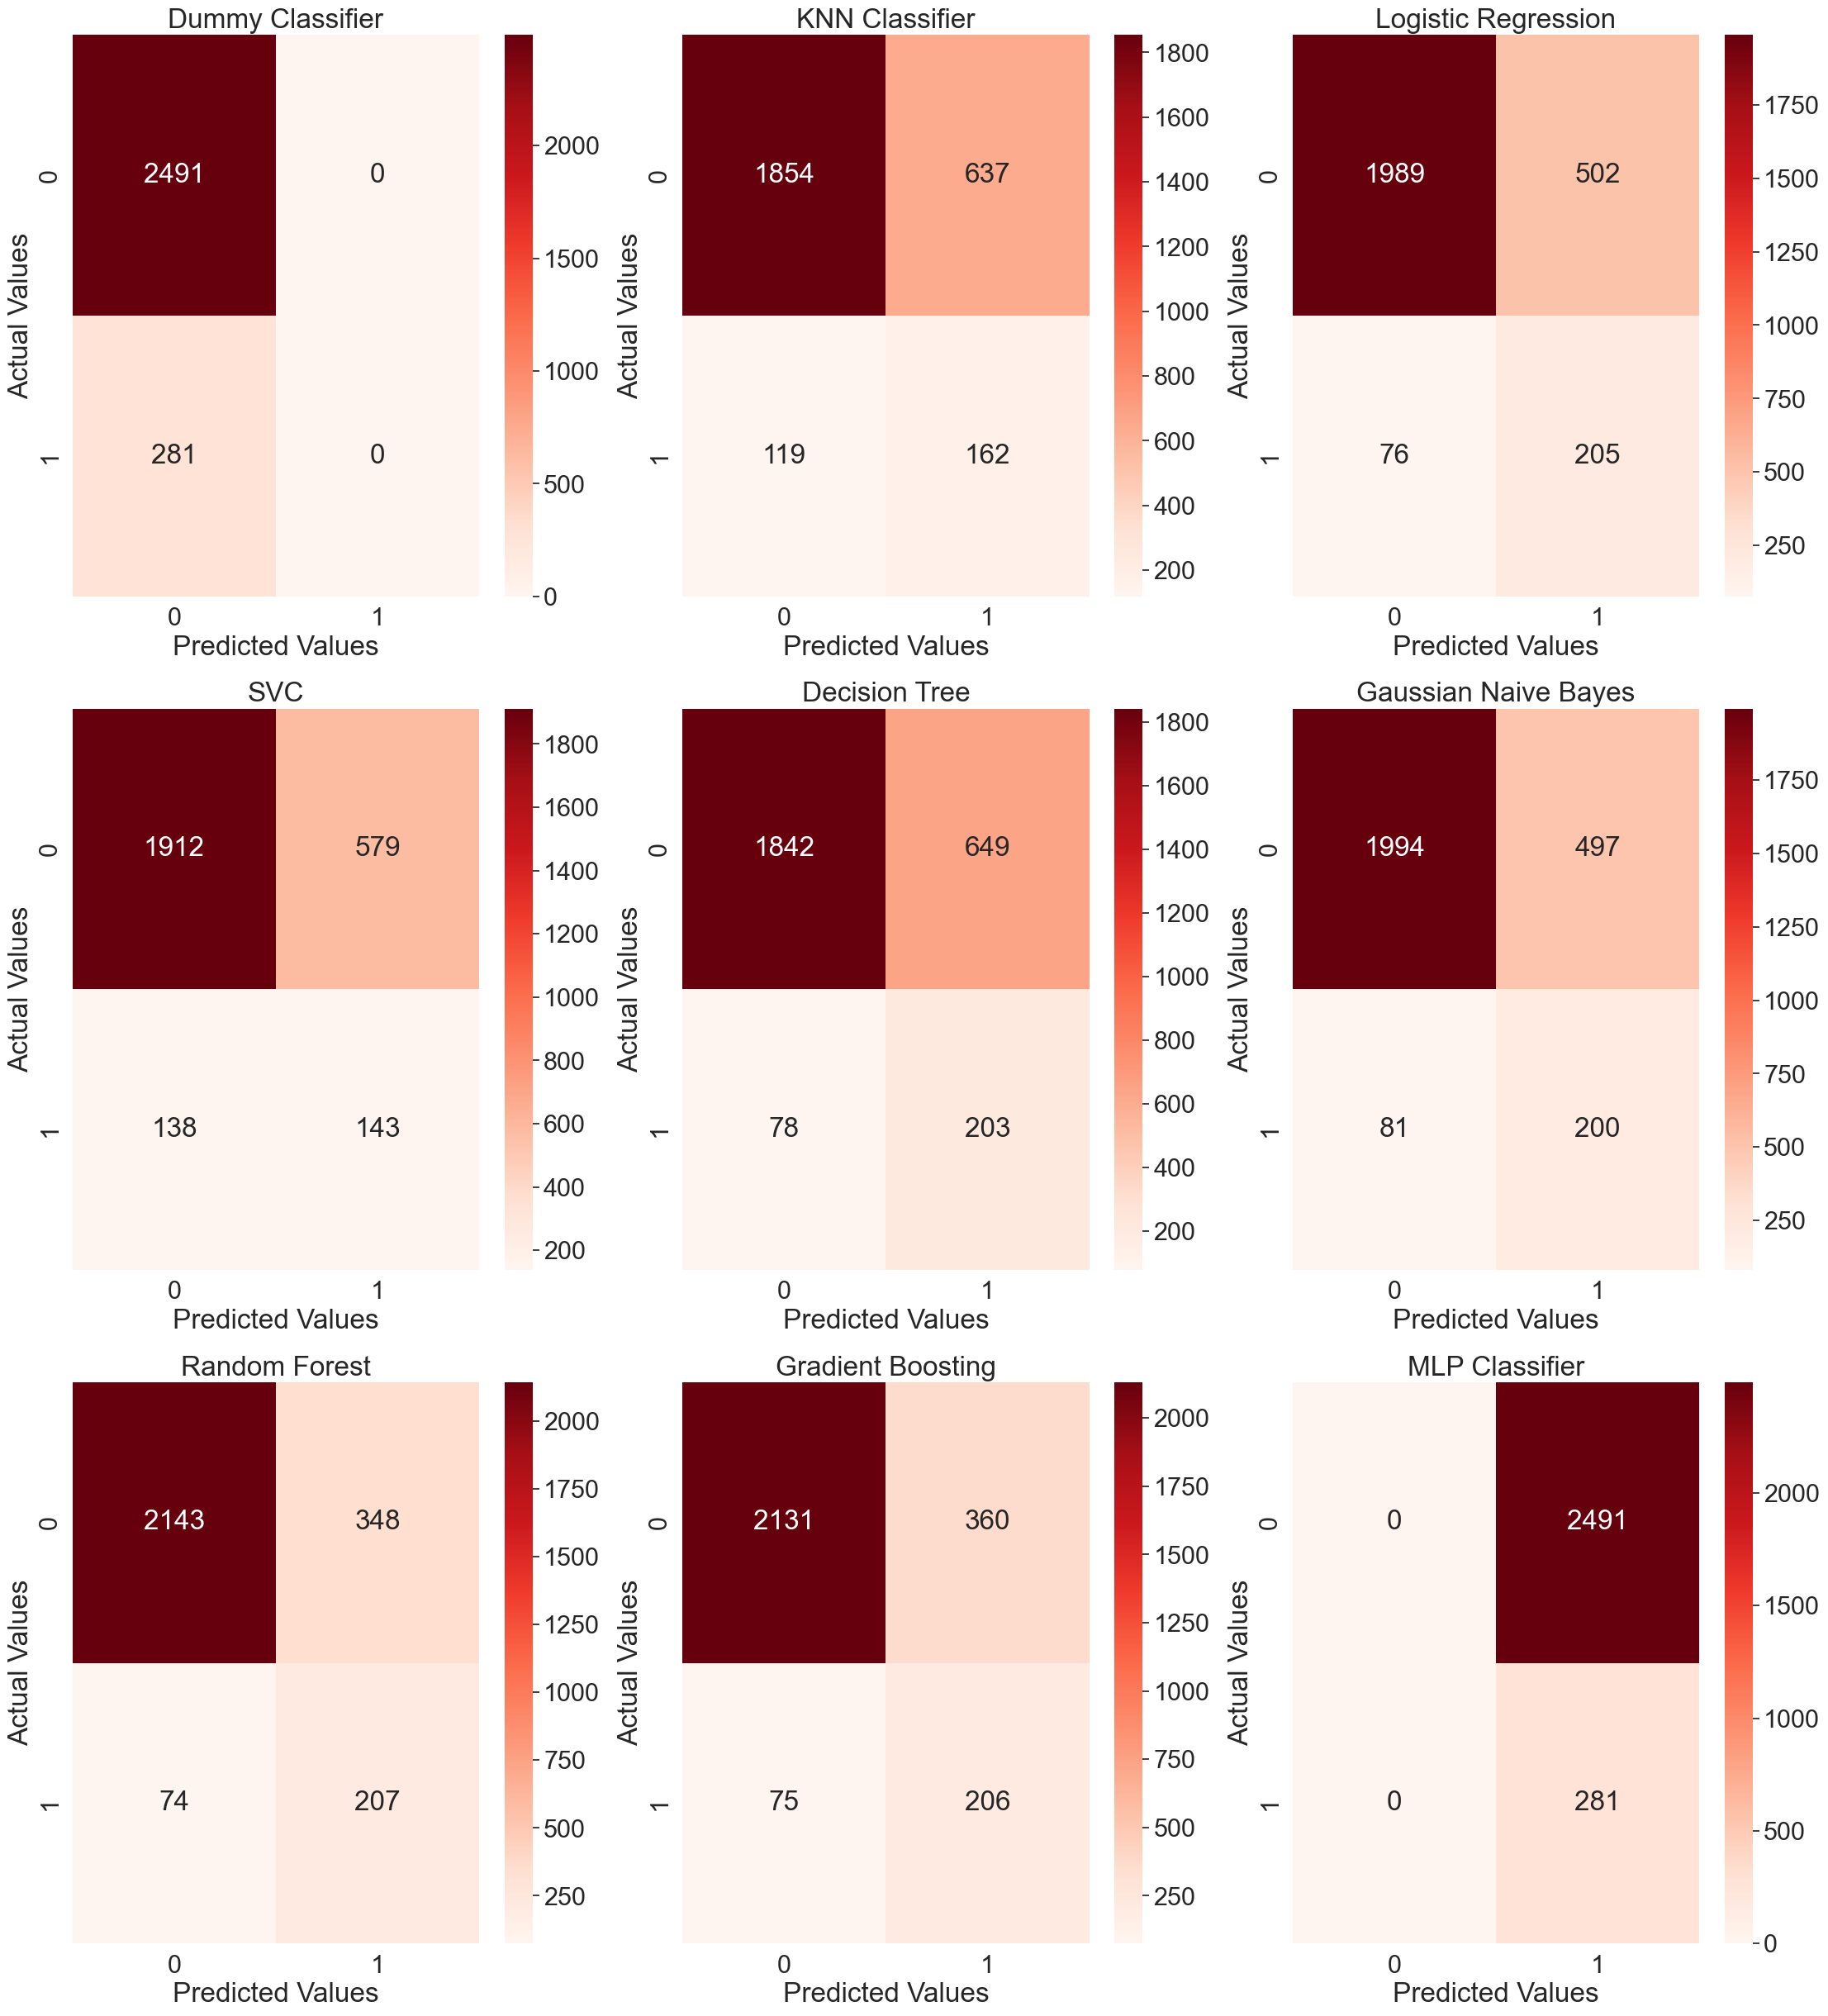

In [49]:
model_pipeline = []
model_pipeline.append(DummyClassifier())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(LogisticRegression(solver="liblinear"))
model_pipeline.append(SVC(probability=True))
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(GaussianNB())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GradientBoostingClassifier())
model_pipeline.append(MLPClassifier())

model_list = ["Dummy Classifier", "KNN Classifier", "Logistic Regression", "SVC", "Decision Tree", "Gaussian Naive Bayes",
            "Random Forest", "Gradient Boosting","MLP Classifier"]
acc_list =[]
auc_list = []
cm_list = []
time_list = []
recall_list = []
precision_list = []

for model in model_pipeline:
    # Some models work better with scaled datasets
    if model in ["KNN Classifier", "SVC", "MLPClassifier"]:
        X_train = X_train_scaled
        X_test = X_test_scaled
    
    # Here I start measuring time
    start = timeit.default_timer()
    
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    acc_list.append(accuracy_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred))
    y_scores = model.predict_proba(X_test) # predict_proba returns 2 columns of data
    fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1]) # I choose the 2nd columns that contains the probabilities of being classified with label 1 (engagement True)
    auc_list.append(round(auc(fpr,tpr),2))
    cm_list.append(confusion_matrix(y_test, y_pred))
    
    end = timeit.default_timer()
    total_time = end - start
    time_list.append(total_time)
    
fig = plt.figure(figsize=(27,30))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(3,3, i+1).set_title(model)
    sns.set(font_scale=2)
    cm_plot = sns.heatmap(cm, annot=True, fmt='g', cmap = "Reds")
    cm_plot.set_xlabel("Predicted Values")
    cm_plot.set_ylabel("Actual Values")


In [50]:
result_df_undersampling_nearmiss = pd.DataFrame({"Model": model_list, "Accuracy":acc_list,"AUROC":auc_list, "Recall":recall_list, "Precision":precision_list, "Time":time_list})
result_df_undersampling_nearmiss = result_df_undersampling_nearmiss.sort_values('AUROC', ascending=False)
result_df_undersampling_nearmiss

,Model,Accuracy,AUROC,Recall,Precision,Time
6,Random Forest,0.847763,0.87,0.736655,0.372973,0.541574
7,Gradient Boosting,0.843074,0.85,0.733096,0.363958,0.430118
2,Logistic Regression,0.791486,0.82,0.729537,0.289958,0.020099
5,Gaussian Naive Bayes,0.791486,0.81,0.711744,0.286944,0.017033
8,MLP Classifier,0.101371,0.74,1.000000,0.101371,0.279539
4,Decision Tree,0.737734,0.73,0.722420,0.238263,0.025389
3,SVC,0.741342,0.70,0.508897,0.198061,1.850972
1,KNN Classifier,0.727273,0.68,0.576512,0.202753,0.273769
0,Dummy Classifier,0.898629,0.50,0.000000,0.000000,0.014862


### Final conclusions

- Having an imbalanced dataset made it difficult to identify/predict the minority class.

- The first step was to use of different classifiers with their default parameters struggled to predict the minority class. As a result, low values of recall metric were obtained, being the best around 40%.

- The next step consisted in doing a grid search of the hyperparameters. Thi took a lot of time and the recall values improved just a little bit (around 44% for the highest scores).

- The last step was to balance the dataset by the use of two undersampling methods: One-Sided Selection and Near Miss version 3. The last method improved the prediction of the minority class thanks to highest values of the recall metric (around 75% for the highest scores). As a secondary effect, the precision metric also decreased, meaning that several negative instances were incorrectly predicted as positive classes (FP increaded).

- The results obtained here show that the use of an undersampling methodology proved to be a good tool to increase the prediction of the minority class in this particular dataset.